<a href="https://colab.research.google.com/github/villafue/LinkedIn_Python_Stastics_Essential_Training/blob/master/05_05_logistic_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python statistics essential training - 05_05_logistic

Standard imports

In [8]:
'''
How can we perform model fitting when the response variables (y variables) are
categorical?

We'll answer the question by following David Kaplan's Statistical Modeling (2017):

We'll use an experiment with the smoking outcomes dataset that we used in chapter
3.
'''

"\nHow can we perform model fitting when the response variables (y variables) are\ncategorical?\n\nWe'll answer the question by following David Kaplan's Statistical Modeling (2017):\n\nWe'll use an experiment with the smoking outcomes dataset that we used in chapter\n3.\n"

In [11]:
import math
import os

In [12]:
os.chdir('sample_data')

FileNotFoundError: ignored

In [13]:
import numpy as np
import pandas as pd

In [14]:
import matplotlib
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [16]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats,'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [17]:
smoking = pd.read_csv("whickham.csv")

In [25]:
display(smoking.head())

,outcome,smoker,age
0,0,Yes,23
1,0,Yes,18
4,0,No,64
5,0,Yes,38
6,0,Yes,45


In [26]:
'''
To strengthen the function of our predictions, he removed cases with ages 
greater than 65 none of whom is alive after 20 years.
'''
smoking = smoking[smoking.age < 65]

In [27]:
color = np.where(smoking.smoker == 'No','skyblue','coral')
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)
def plotfit(fit):
    plt.scatter(smoking.age,smoking.outcome + jitter,c=color,linewidth=0.2,edgecolor='k',alpha=0.5)
    plt.scatter(smoking.age,fit.predict(smoking),c=color,linewidth=0.2,edgecolor='gray',marker='d')

In [28]:
'''
If I convert the smoking outcome to a binary number, it becomes possible to do 
OLS (Ordinary Least Squares) test.

We'll try this first but there is a much better way.

A good Python trick is multiplying a boolean by an integer returns an integer.
(1*...as seen below)
'''
smoking['outcome'] = 1*(smoking['outcome'] == 'Alive')

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [33]:
smoking['outcome']

0       0
1       0
4       0
5       0
6       0
       ..
1309    0
1310    0
1311    0
1312    0
1313    0
Name: outcome, Length: 1071, dtype: int64

In [29]:
ols_group_age = smf.ols('outcome ~ smoker + age',data=smoking).fit()

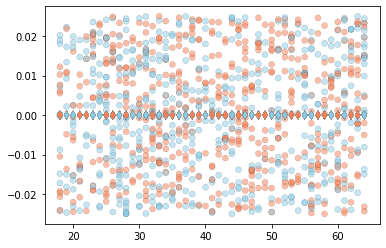

In [31]:
'''
This is not what it is supposed to look like. He says that the data is plotted as
circles, with orange for smokers, and light-blue for non-smokers. I have added
some jitter (which means moved the points randomly up and down so they don't all
lie on top of each other).
'''
plotfit(ols_group_age)

In [32]:
'''
This is what is supposed to be the parameters:
Intercept:      1.264
Smoker[T.Yes]: -0.03873
age:           -0.009615

There is an association with smoking and negative outcomes. This is because the 
smoker term is negative.
'''
ols_group_age.params

Intercept        0.0
smoker[T.Yes]    0.0
age              0.0
dtype: float64

In [ ]:
'''
Association is not very strong as it only has an F-statistic of 8. We have 
confirmation of this in the confidence intervals that statsmodels provides in the
parameters. Those rely from specific mathematical assumptions about the data, so
they should be taken with a grain of salt.

'''
sm.stats.anova_lm(ols_group_age)

/Users/vallis/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/vallis/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/vallis/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


In [ ]:
'''
The plot however shows a mathematical problem. Some prediced outcomes are larger
than one. How can we interperit that?

What we need is to limit the output of the model to values zero and one, or perhaps
even better, to values between zero and one that can be understood as the probability
of one of the two outcomes.

This is done by constructing models in the usual way and then applying a non-linear
function to the output. One especially useful non-linear function is the exponential
logistic transformation. The process of fitting such a model is called logistic
regression.

Standard Linear Model (outputs in [-infiniti, infiniti]) -> 
Logistic Transformation (exp(y) / (1 + exp(y))) -> Probability (in [0,1])


'''

In [ ]:
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


In [ ]:
'''
Stats models implements it as logit
'''
logit_smoker_age = smf.logit('outcome ~ smoker + age',data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


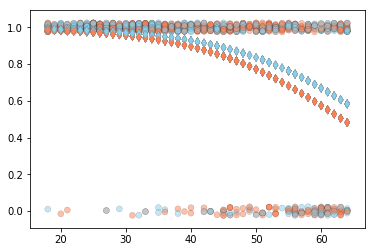

In [ ]:
'''
We see now that the model is bounded between 0 and 1, and it displays a nonlinear
behavior even if we have all linear main terms. The criteria for logistic regression
is not minimizing the mean-square error of the residuals, but rather interpreting
the model response as a probability function and maximizing the resulting probability
of the observed data. This is a form of maximum-likelihood estimation.
'''
plotfit(logit_smoker_age)

In [ ]:
'''
So instead of the mean square error, the simplest way to characterize goodness of 
fit is the value of the likelihood
'''
logit_smoker_age.llf

-371.38650786619064

In [ ]:
'''
Because of the logistic transformation, the model parameters are not directly
comparable with the least-squares parameters

Smoking reduces the probability of being alive, but not uniformly. It does so by
0.1 at the upper end of the ages, and less for younger subjects.

From the confidence intervals, the association with smoking emains weak.
'''
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

In [ ]:
'''
StatsModels can tell us a lot more about this logistic regression fit.
'''

logit_smoker_age.conf_int()

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


In [ ]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:                  0.1776
Time:                        19:19:04   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
                                        LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

In [ ]:
'''
Understanding the above numbers requires some mathematical development. Note that 
the logistic model probabilities are conditional probabilities. They depend on the
value of the explanatory variables and they refer directly to the cases in the data
set, but not necessarily to the general population. Unless we can determine that
the sample is truly representative of the population. The techniques to extrapolate
the results from sample to population are beyond the scope of this course.
'''